In [1]:
import pandas as pd
import numpy as np

import scipy.stats as stats
from scipy.stats import kendalltau
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from math import sqrt
import matplotlib.pyplot as plt
from pyEDM import *

import warnings
warnings.filterwarnings('ignore')

### 一、載入資料

1.1.載入資料

In [2]:
data = pd.read_csv('/Users/yitsung/git/MastersThesis/data/TaiwanStockData_Top100_EMA')
ticker_2330 = data[data['ticker']==2330].reset_index(drop=True)
ticker_2330 = ticker_2330.drop(columns=['ticker'])
ticker_2330.tail()

,Date,open,high,low,close,volume,financing,fi,ii,di,rp,capital,EMA9,EMA12,EMA26,MACD,Signal,RSI14
704,2023-11-27,573.0,577.0,568.0,568.0,20322.0,-112.0,-2153.0,59.0,-56.0,-3554.0,4.1507,573.659169,571.840469,562.945683,8.894786,9.086560,81.069290
705,2023-11-28,565.0,576.0,565.0,575.0,26932.0,478.0,3323.0,-98.0,687.0,-416.0,5.1624,573.927335,572.326550,563.838595,8.487955,8.966839,76.500832
706,2023-11-29,578.0,579.0,570.0,574.0,27787.0,357.0,-180.0,55.0,-553.0,-2383.0,4.8624,573.941868,572.584004,564.591292,7.992712,8.772014,71.301362
707,2023-11-30,576.0,577.0,570.0,577.0,54365.0,-32.0,4730.0,-68.0,-770.0,-155.0,7.5527,574.553494,573.263388,565.510455,7.752933,8.568197,68.146342
708,2023-12-01,573.0,579.0,573.0,579.0,28798.0,-260.0,7120.0,-611.0,-1060.0,2874.0,5.4736,575.442796,574.145944,566.509681,7.636263,8.381811,61.941017


1.2.轉換成EMA+return data

In [3]:
# ticker_2330 = ticker_2330[['Date', 'open', 'high', 'low', 'close', 'volume', 'financing', 'fi', 'ii', 'di', 'rp', 'capital', 'MACD', 'Signal', 'RSI14']]
# # 計算MA
# ticker_2330['5MA'] = ticker_2330['close'].rolling(window=5).mean()
# ticker_2330['10MA'] = ticker_2330['close'].rolling(window=10).mean()
# ticker_2330['20MA'] = ticker_2330['close'].rolling(window=20).mean()

# 取differ
feature_to_differ = ['financing', 'fi', 'ii']
ticker_2330[feature_to_differ] = ticker_2330[feature_to_differ].diff()

# # 增加價格距離SMA feature
# ticker_2330['5MA_dis'] = (ticker_2330['5MA'] - ticker_2330['close']) / ticker_2330['close']
# ticker_2330['10MA_dis'] = (ticker_2330['10MA'] - ticker_2330['close']) / ticker_2330['close']
# ticker_2330['20MA_dis'] = (ticker_2330['20MA'] - ticker_2330['close']) / ticker_2330['close']

# origi_data
origi_data = ticker_2330.copy() # 用來之後還原答案的

# 把價格變成報酬率
ticker_2330['open'] = (ticker_2330['open'] - ticker_2330['open'].shift(1)) / ticker_2330['open'].shift(1)
ticker_2330['high'] = (ticker_2330['high'] - ticker_2330['high'].shift(1)) / ticker_2330['high'].shift(1)
ticker_2330['low'] = (ticker_2330['low'] - ticker_2330['low'].shift(1)) / ticker_2330['low'].shift(1)
ticker_2330['close'] = (ticker_2330['close'] - ticker_2330['close'].shift(1)) / ticker_2330['close'].shift(1)

ticker_2330.replace([float('inf'), -float('inf')], 0, inplace=True) # 不知道為何有些調整過後會變inf, 要拿掉(應該是連兩天的價格都相同)
ticker_2330 = ticker_2330.dropna().reset_index(drop=True)

ticker_2330.tail()

,Date,open,high,low,close,volume,financing,fi,ii,di,rp,capital,EMA9,EMA12,EMA26,MACD,Signal,RSI14
703,2023-11-27,-0.006932,-0.001730,-0.010453,-0.012174,20322.0,-355.0,-1299.0,-11.0,-56.0,-3554.0,4.1507,573.659169,571.840469,562.945683,8.894786,9.086560,81.069290
704,2023-11-28,-0.013962,-0.001733,-0.005282,0.012324,26932.0,590.0,5476.0,-157.0,687.0,-416.0,5.1624,573.927335,572.326550,563.838595,8.487955,8.966839,76.500832
705,2023-11-29,0.023009,0.005208,0.008850,-0.001739,27787.0,-121.0,-3503.0,153.0,-553.0,-2383.0,4.8624,573.941868,572.584004,564.591292,7.992712,8.772014,71.301362
706,2023-11-30,-0.003460,-0.003454,0.000000,0.005226,54365.0,-389.0,4910.0,-123.0,-770.0,-155.0,7.5527,574.553494,573.263388,565.510455,7.752933,8.568197,68.146342
707,2023-12-01,-0.005208,0.003466,0.005263,0.003466,28798.0,-228.0,2390.0,-543.0,-1060.0,2874.0,5.4736,575.442796,574.145944,566.509681,7.636263,8.381811,61.941017


1.3.切Library和Prediction

In [4]:
Library = ticker_2330[ticker_2330['Date'] < '2023-07-01']
Prediction = ticker_2330[ticker_2330['Date'] >= '2023-07-01']
Prediction

,Date,open,high,low,close,volume,financing,fi,ii,di,rp,capital,EMA9,EMA12,EMA26,MACD,Signal,RSI14
602,2023-07-03,0.014035,0.006944,0.014085,0.005208,15118.0,-20.0,4926.0,-39042.0,1401.0,582.0,2.5477,576.701182,575.940219,566.756798,9.183421,11.833896,33.311646
603,2023-07-04,0.012111,0.008621,0.006944,0.010363,17777.0,-13.0,2452.0,-1043.0,-13.0,1767.0,2.7068,578.360946,577.334031,568.108146,9.225886,11.312294,30.627646
604,2023-07-05,0.006838,0.006838,-0.001724,-0.005128,15554.0,-134.0,-5695.0,845.0,-1092.0,-790.0,2.6473,579.088757,578.051873,569.137172,8.914701,10.832775,17.707207
605,2023-07-06,-0.027165,-0.025467,-0.024180,-0.029210,32070.0,613.0,-15586.0,-71.0,-603.0,-14045.0,5.1447,576.271005,576.043892,568.830715,7.213177,10.108856,7.697299
606,2023-07-07,-0.013962,-0.003484,-0.003540,0.000000,19859.0,-531.0,11990.0,389.0,-100.0,-1681.0,3.6264,574.016804,574.344832,568.546958,5.797874,9.246659,1.662877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,2023-11-27,-0.006932,-0.001730,-0.010453,-0.012174,20322.0,-355.0,-1299.0,-11.0,-56.0,-3554.0,4.1507,573.659169,571.840469,562.945683,8.894786,9.086560,81.069290
704,2023-11-28,-0.013962,-0.001733,-0.005282,0.012324,26932.0,590.0,5476.0,-157.0,687.0,-416.0,5.1624,573.927335,572.326550,563.838595,8.487955,8.966839,76.500832
705,2023-11-29,0.023009,0.005208,0.008850,-0.001739,27787.0,-121.0,-3503.0,153.0,-553.0,-2383.0,4.8624,573.941868,572.584004,564.591292,7.992712,8.772014,71.301362
706,2023-11-30,-0.003460,-0.003454,0.000000,0.005226,54365.0,-389.0,4910.0,-123.0,-770.0,-155.0,7.5527,574.553494,573.263388,565.510455,7.752933,8.568197,68.146342


1.3.標準化(Minmax)

In [5]:
def make_data_minmax(Library, Prediction):

    ### 標準化Library ###
    feature_to_standardize = Library.columns.to_list()[1:]
    scaler_Train_X = MinMaxScaler()
    Library[feature_to_standardize] = scaler_Train_X.fit_transform(Library[feature_to_standardize])
    # Library.tail()

    ### 標準化Prediction ###
    feature_to_standardize = Library.columns.to_list()
    feature_to_standardize.remove(Library.columns[0])  # 排除Date
    feature_to_standardize.remove(Library.columns[4])  # 排除close

    scaler_Prediction_X = MinMaxScaler() # 處理target以外的feature
    Prediction[feature_to_standardize] = scaler_Prediction_X.fit_transform(Prediction[feature_to_standardize])

    scaler_Prediction_y = MinMaxScaler() # 處理target feature
    close = Prediction['close'].values.reshape(-1, 1)
    Prediction['close'] = scaler_Prediction_y.fit_transform(close)
    # Prediction.tail()

    ### 把Library和Prediction結合在一起 ###
    ticker_2330 = pd.concat([Library, Prediction], axis=0)
    # ticker_2330.tail()

    return ticker_2330, Library, Prediction, scaler_Prediction_y

In [6]:
ticker_2330, Library, Prediction, scaler_Prediction_y = make_data_minmax(Library=Library, Prediction=Prediction)

In [7]:
### 測試用1(用訓練集的轉換還原) ###

def make_data_minmax_test1(Library, Prediction):

    ### 標準化Library ###
    feature_to_standardize = Library.columns.to_list()
    feature_to_standardize.remove(Library.columns[0])  # 排除Date
    feature_to_standardize.remove(Library.columns[4])  # 排除close

    scaler_X = StandardScaler() # 處理target以外的feature
    Library[feature_to_standardize] = scaler_X.fit_transform(Library[feature_to_standardize])
    Prediction[feature_to_standardize] = scaler_X.fit_transform(Prediction[feature_to_standardize])

    scaler_y = StandardScaler() # 處理target feature
    close = Library['close'].values.reshape(-1, 1)
    Library['close'] = scaler_y.fit_transform(close)
    close = Prediction['close'].values.reshape(-1, 1)
    Prediction['close'] = scaler_y.fit_transform(close)

    ### 把Library和Prediction結合在一起 ###
    ticker_2330 = pd.concat([Library, Prediction], axis=0)
    # ticker_2330.tail()

    return ticker_2330, Library, Prediction, scaler_y

# ticker_2330, Library, Prediction, scaler_y = make_data_minmax_test1(Library=Library, Prediction=Prediction)

### 二、Simplex演算法

2.1.製作可餵入EDM格式的train_feature

In [8]:
def find_train_target_feature(data, target):

    df_columns = list(data.columns)
    train_feature = df_columns.copy()
    train_feature.remove('Date') # 先拿掉日期

    formatted_columns = ' '.join(df_columns[1:]) # 變成可以餵給 EDM function 參數 'columns' 的形式 
    train_feature.remove(target) # 再拿掉 target_feature

    return formatted_columns, train_feature

In [9]:
formatted_columns, train_feature = find_train_target_feature(data=Library, target='close')
formatted_columns

'open high low close volume financing fi ii di rp capital EMA9 EMA12 EMA26 MACD Signal RSI14'

2.2. 尋找target_feature最合適的嵌入維度

In [10]:
def find_target_OED(data, target):
    
    target_OED = EmbedDimension(dataFrame=data, lib=f'1 {len(data)}', pred=f'{len(data)-21} {len(data)-1}', columns=target, showPlot=False) # 4. lib訓練全部, pred看最後20筆

    target_OED_rho = target_OED['rho'].max()
    target_OED = int(target_OED['E'][target_OED['rho'] == target_OED['rho'].max()].iloc[0])

    return target_OED, target_OED_rho

In [11]:
target_OED, target_OED_rho = find_target_OED(data=Library, target='close')
print(f'target_OED: {target_OED}, target_OED_rho: {target_OED_rho}')

target_OED: 10, target_OED_rho: 0.19332783439872728


2.3.尋找每個train_feature與target_feature的因果性

In [12]:
def find_rho_sig_df(data, ticker, target, target_OED, train_feature, E_max):
    
    crirho = stats.t.ppf(0.95, len(data) - 1) / (len(data) - 2 + stats.t.ppf(0.95, len(data) - 1) ** 2)
    ccm_libSizes = f'{target_OED+10} {len(data)-10} 10'
    # ccm_libSizes = list(range(10, len(data) + 1, 10)) + [len(data)]  # sequence of library size # original

    rho_sig_df = pd.DataFrame(columns=train_feature)
    for train in train_feature:

        ### 找出該train_feature最好的ccm_OED ###
        ccm_E_termRHO = pd.DataFrame(columns=['E', 'term_rho'])
        """
        這裡假設用 term_rho 來選 ccm_OED
        """
        for e in range(1, E_max+1):
            ccm_result = CCM(dataFrame=data, E=e, columns=train, target=target,
                            libSizes=ccm_libSizes, random=False, showPlot=False)
            # print(e, ccm_result[f'{target}:open'].iloc[-1]) # 有時候會有warning, 測試用
            new_data = {'E': e, 'term_rho': ccm_result[f'{target}:{train}'].iloc[-1]}
            ccm_E_termRHO.loc[len(ccm_E_termRHO)] = new_data

        max_term_rho_index = ccm_E_termRHO['term_rho'].idxmax()
        ccm_OED = ccm_E_termRHO.at[max_term_rho_index, 'E']

        ### 用最好的ccm_OED來做該feature的因果檢定 ###
        ccm_result = CCM(dataFrame=data, E=ccm_OED, columns=train, target=target, 
                        libSizes=ccm_libSizes, random=False, showPlot=False)
        """
        這裡假設用 target:train 、 LibSize 來做 kendalltau 檢定
        """
        ccm_result = ccm_result[['LibSize', f'{target}:{train}']]
        ccm_result[f'{target}:{train}'][ccm_result[f'{target}:{train}'] < 0] = 0
        term_rho = ccm_result[f'{target}:{train}'].iloc[-1]

        tau, p_value = kendalltau(ccm_result['LibSize'], ccm_result[f'{target}:{train}']) # 進行 kendalltau 相關檢定

        alpha = 0.05
        if (p_value < alpha) and (term_rho > crirho): # 顯著相關
            rho_sig_df[train] = [term_rho]

        else: # "不" 顯著相關
            rho_sig_df[train] = [0]

    rho_sig_df.index = pd.Index([f'{ticker}_{target}']) 
    
    return rho_sig_df

In [13]:
rho_sig_df = find_rho_sig_df(data=Library, ticker=2330, target='close', target_OED=target_OED, train_feature=train_feature, E_max=10)
rho_sig_df

,open,high,low,volume,financing,fi,ii,di,rp,capital,EMA9,EMA12,EMA26,MACD,Signal,RSI14
2330_close,0.649866,0.827375,0.780578,0.608145,0.373125,0.733818,0.023472,0.235811,0.7407,0.609476,0.265758,0.258865,0.25996,0.501982,0.193481,0.561763


2.4. 用有因果關係的train_feature建立Embed_df

In [14]:
def make_Embed_df(data, max_lag, target, rho_sig_df):

    #用有因果關係的 train feature + target feature 製作 Embed_df #
    non_zero_columns = rho_sig_df.loc[:, (rho_sig_df != 0).any(axis = 0)] # 選取值非0的column
    train_feature_ls = list(non_zero_columns.columns)
    formatted_columns = ' '.join(train_feature_ls) # 轉成 EDM column 的 input
    columns_to_lag = formatted_columns + f' {target}' # 加入 target 本身

    Embed_df = Embed(dataFrame=data, E=max_lag, tau=-1, columns=columns_to_lag) # 製作 Embed_df
    Embed_df['Date'] = data['Date'] # 加入Date來看index, 才可以防simplex func的bug
    Embed_df.dropna(inplace=True) # 把包含NaN的資料拿掉
    Embed_df = Embed_df.reset_index(drop=True)
    Embed_df = Embed_df[['Date'] + [col for col in Embed_df.columns if col != 'Date']]

    ML_df_date = Embed_df.copy()
    ML_df_date['Date'] = pd.to_datetime(ML_df_date['Date']) # 將index設為日期
    ML_df_date.set_index('Date', inplace=True)
    ML_df_date = ML_df_date.filter(like="(t-0)") # 只留下(t-0)的column
    ML_df_date[f'{target}(t-0)'] = ML_df_date[f'{target}(t-0)'].astype(int)

    return Embed_df, ML_df_date

In [15]:
Embed_df, ML_df_date = make_Embed_df(data=Library, max_lag=10, target='close', rho_sig_df=rho_sig_df)
Embed_df.tail()

,Date,open(t-0),open(t-1),open(t-2),open(t-3),open(t-4),open(t-5),open(t-6),open(t-7),open(t-8),...,close(t-0),close(t-1),close(t-2),close(t-3),close(t-4),close(t-5),close(t-6),close(t-7),close(t-8),close(t-9)
588,2023-06-26,0.471196,0.562445,0.491508,0.462036,0.531924,0.531924,0.502123,0.726907,0.668425,...,0.427449,0.479123,0.499693,0.438610,0.479401,0.509857,0.469358,0.698178,0.595210,0.564055
589,2023-06-27,0.470564,0.471196,0.562445,0.491508,0.462036,0.531924,0.531924,0.502123,0.726907,...,0.478800,0.427449,0.479123,0.499693,0.438610,0.479401,0.509857,0.469358,0.698178,0.595210
590,2023-06-28,0.624932,0.470564,0.471196,0.562445,0.491508,0.462036,0.531924,0.531924,0.502123,...,0.520660,0.478800,0.427449,0.479123,0.499693,0.438610,0.479401,0.509857,0.469358,0.698178
591,2023-06-29,0.521750,0.624932,0.470564,0.471196,0.562445,0.491508,0.462036,0.531924,0.531924,...,0.489247,0.520660,0.478800,0.427449,0.479123,0.499693,0.438610,0.479401,0.509857,0.469358
592,2023-06-30,0.450393,0.521750,0.624932,0.470564,0.471196,0.562445,0.491508,0.462036,0.531924,...,0.531088,0.489247,0.520660,0.478800,0.427449,0.479123,0.499693,0.438610,0.479401,0.509857


2.5. 用simplex randomsearch找出最佳的view

In [16]:
def make_random_simplex(Embed_df, target, target_OED, kmax, kn):

    np.random.seed(87)
    Embed_for_train = Embed_df.drop(columns='Date') # 先把 Date 拿掉
    Embed_for_train = Embed_for_train.drop(columns=f'{target}(t-0)') # 先把 target 拿掉
    train_f_ls = list(Embed_for_train.columns) # train_feature
    train_f_num = len(Embed_for_train.columns) # train_feature 的個數

    rho_feature_view = pd.DataFrame(columns=['rho']) # 創建一個df去紀錄每個隨機view的資料
    new_column = pd.DataFrame(columns=['feature_' + str(i) for i in range(1, target_OED+1)])
    rho_feature_view = pd.concat([rho_feature_view, new_column], axis=1)
    k = 1
    while k <= kmax:
            
        random_pick_train = np.random.choice(train_f_num, target_OED, replace=False)
        train_f_ls = np.array(train_f_ls) # 變成 array 才可以一次選
        select_train_f = train_f_ls[random_pick_train] # 隨機選到的 train_feature
        formatted_random_columns = ' '.join(select_train_f) # 用成符合 EDM 的資料格式
        # print(formatted_random_columns)

        simp = Simplex(dataFrame=Embed_df, E=target_OED, # ver3: 測試近10 or 20個交易日
                       lib=f'1 {len(Embed_df)}', pred = f'{len(Embed_df)-21} {len(Embed_df)-1}', 
                       columns=formatted_random_columns, target=f'{target}(t-0)',
                       embedded = True, showPlot = False) # 原本是False現在改True
        # print(simp)

        sub_simp = simp[['Observations', 'Predictions']] # 計算rho
        rho = sub_simp['Observations'].corr(sub_simp['Predictions'])
        rho_feature_view.loc[len(rho_feature_view), 'rho'] = rho # 將 view 更新到 rho_feature_view 的 df 中
        rho_feature_view.loc[len(rho_feature_view)-1, rho_feature_view.columns[1:]] = select_train_f

        # print(rho)
        k += 1

    allscore = rho_feature_view.sort_values(by='rho', ascending=False).head(kn)
    allscore = allscore.reset_index(drop=True)

    return allscore

In [17]:
allscore = make_random_simplex(Embed_df=Embed_df, target='close', target_OED=target_OED, kmax=10000, kn=100)
allscore.head()

,rho,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10
0,0.572295,EMA9(t-1),close(t-6),MACD(t-9),open(t-6),low(t-1),MACD(t-8),capital(t-8),EMA26(t-1),low(t-3),fi(t-9)
1,0.568156,EMA9(t-0),MACD(t-6),Signal(t-9),Signal(t-5),EMA12(t-8),open(t-2),RSI14(t-9),open(t-7),MACD(t-2),volume(t-4)
2,0.554712,capital(t-9),RSI14(t-0),volume(t-5),capital(t-0),EMA9(t-7),fi(t-1),capital(t-4),financing(t-8),di(t-7),EMA9(t-9)
3,0.539271,financing(t-3),volume(t-7),di(t-1),EMA9(t-1),financing(t-2),ii(t-6),open(t-3),high(t-4),rp(t-0),capital(t-2)
4,0.512586,open(t-9),rp(t-4),high(t-0),MACD(t-9),capital(t-9),EMA26(t-6),EMA12(t-5),close(t-3),rp(t-9),low(t-8)


2.6.利用Mutiview建立預測

In [18]:
Embed_df_complete, ML_df_date = make_Embed_df(data=ticker_2330, # 這裡要用全data
                                              max_lag=10, target='close', 
                                              rho_sig_df=rho_sig_df)
Embed_df_complete

,Date,open(t-0),open(t-1),open(t-2),open(t-3),open(t-4),open(t-5),open(t-6),open(t-7),open(t-8),...,close(t-0),close(t-1),close(t-2),close(t-3),close(t-4),close(t-5),close(t-6),close(t-7),close(t-8),close(t-9)
0,2021-01-18,0.408611,0.873115,0.452723,0.653170,0.593177,0.501455,0.808376,0.521310,0.740731,...,0.559557,0.590854,0.370847,0.641738,0.571567,0.541047,0.658888,0.674450,0.577137,0.566816
1,2021-01-19,0.628808,0.408611,0.873115,0.452723,0.653170,0.593177,0.501455,0.808376,0.521310,...,0.697266,0.559557,0.590854,0.370847,0.641738,0.571567,0.541047,0.658888,0.674450,0.577137
2,2021-01-20,0.674898,0.628808,0.408611,0.873115,0.452723,0.653170,0.593177,0.501455,0.808376,...,0.690964,0.697266,0.559557,0.590854,0.370847,0.641738,0.571567,0.541047,0.658888,0.674450
3,2021-01-21,0.597064,0.674898,0.628808,0.408611,0.873115,0.452723,0.653170,0.593177,0.501455,...,0.740658,0.690964,0.697266,0.559557,0.590854,0.370847,0.641738,0.571567,0.541047,0.658888
4,2021-01-22,0.614760,0.597064,0.674898,0.628808,0.408611,0.873115,0.452723,0.653170,0.593177,...,0.285857,0.740658,0.690964,0.697266,0.559557,0.590854,0.370847,0.641738,0.571567,0.541047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,2023-11-27,0.354455,0.510887,0.398972,0.311009,0.577663,0.376983,0.399357,0.399509,0.599999,...,0.300018,0.401524,0.502155,0.278197,0.678488,0.401784,0.402171,0.526999,0.705660,0.502420
695,2023-11-28,0.264019,0.354455,0.510887,0.398972,0.311009,0.577663,0.376983,0.399357,0.399509,...,0.656092,0.300018,0.401524,0.502155,0.278197,0.678488,0.401784,0.402171,0.526999,0.705660
696,2023-11-29,0.739670,0.264019,0.354455,0.510887,0.398972,0.311009,0.577663,0.376983,0.399357,...,0.451687,0.656092,0.300018,0.401524,0.502155,0.278197,0.678488,0.401784,0.402171,0.526999
697,2023-11-30,0.399127,0.739670,0.264019,0.354455,0.510887,0.398972,0.311009,0.577663,0.376983,...,0.552931,0.451687,0.656092,0.300018,0.401524,0.502155,0.278197,0.678488,0.401784,0.402171


In [19]:
def mutiview(allscore, Embed_df, target, origi_data):

    mv_columns_all = allscore.iloc[:, 1:]
    mv_rho = allscore.iloc[:, 0]
    mv_rho_sum = mv_rho.sum()

    for i in range(len(mv_columns_all)):

        if i == 0:
            mv_columns = mv_columns_all.iloc[i].tolist()
            mv_columns = ' '.join(mv_columns)
            mv_simplex = Simplex(dataFrame=Embed_df,
                                 lib=f'1 {len(Embed_df)-107}', pred = f'{len(Embed_df)-106} {len(Embed_df)-2}', 
                                 columns=mv_columns, target=f'{target}(t-0)',
                                 embedded=True, showPlot=False)        

            w = mv_rho[i] / mv_rho_sum

            # 將資料轉換成二維格式
            Observations = np.array(mv_simplex['Observations']).reshape(-1, 1)
            Predictions = np.array(mv_simplex['Predictions']).reshape(-1, 1)

            # 進行inverse_transform
            mv_simplex['Observations'] = scaler_Prediction_y.inverse_transform(Observations) # scaler_y # scaler_Prediction_y
            mv_simplex['Predictions'] = scaler_Prediction_y.inverse_transform(Predictions) # scaler_y # scaler_Prediction_y
            mv_simplex['Predictions']  = mv_simplex['Predictions'] * w

        if i > 0:
            mv_columns = mv_columns_all.iloc[i].tolist()
            mv_columns = ' '.join(mv_columns)
            new_simplex = Simplex(dataFrame=Embed_df,
                                  lib=f'1 {len(Embed_df)-107}', pred = f'{len(Embed_df)-106} {len(Embed_df)-2}', 
                                  columns=mv_columns, target=f'{target}(t-0)',
                                  embedded=True, showPlot=False)        

            w = mv_rho[i] / mv_rho_sum

            # 將資料轉換成二維格式
            Observations = np.array(new_simplex['Observations']).reshape(-1, 1)
            Predictions = np.array(new_simplex['Predictions']).reshape(-1, 1)

            # 進行inverse_transform
            new_simplex['Observations'] = scaler_Prediction_y.inverse_transform(Observations) # scaler_y # scaler_Prediction_y
            new_simplex['Predictions'] = scaler_Prediction_y.inverse_transform(Predictions) # scaler_y # scaler_Prediction_y
            mv_simplex['Predictions']  = mv_simplex['Predictions'] + (new_simplex['Predictions'] * w)            

    yesterday = origi_data['close'][(origi_data['Date']>='2023-06-30') & (origi_data['Date']<'2023-11-30')].reset_index(drop=True)
    yesterday = pd.Series(yesterday)

    mv_simplex['Yesterday'] = mv_simplex['Observations'].shift(1)
    mv_simplex = mv_simplex.drop(columns=['Pred_Variance'])
    mutiview = mv_simplex.dropna().reset_index(drop=True)

    mutiview['Predictions'] = (1 + mutiview['Predictions']) * yesterday
    mutiview['Observations'] = (1 + mutiview['Observations']) * yesterday
    mutiview['Yesterday'] = yesterday
    
    return mutiview

In [20]:
mutiview_result = mutiview(allscore=allscore, 
                           Embed_df=Embed_df_complete, 
                           target='close',
                           origi_data=origi_data)
mutiview_result

,Date,Observations,Predictions,Yesterday
0,2023-07-03,579.0,576.793031,576.0
1,2023-07-04,585.0,579.444308,579.0
2,2023-07-05,582.0,585.292990,585.0
3,2023-07-06,565.0,582.317562,582.0
4,2023-07-07,565.0,564.875949,565.0
...,...,...,...,...
100,2023-11-24,575.0,579.002003,578.0
101,2023-11-27,568.0,575.879068,575.0
102,2023-11-28,575.0,568.858458,568.0
103,2023-11-29,574.0,575.444995,575.0


### 三、評估Mutiview結果

In [21]:
def make_result(mutiview_result):

    plt.figure(figsize=(16, 9))
    plt.plot(mutiview_result['Date'], mutiview_result[f'Observations'], linewidth=3, label='true')
    plt.plot(mutiview_result['Date'], mutiview_result[f'Predictions'], linewidth=3, label='pred')
    plt.plot(mutiview_result['Date'], mutiview_result[f'Yesterday'], linestyle='--', label='yesterday')

    plt.xlabel('Date')
    plt.xticks(rotation=90, ha='right')
    plt.ylabel('Price')
    plt.title(f'2330 EMA+return Mutiview: close')
    plt.legend()
    plt.show()

    return mutiview_result

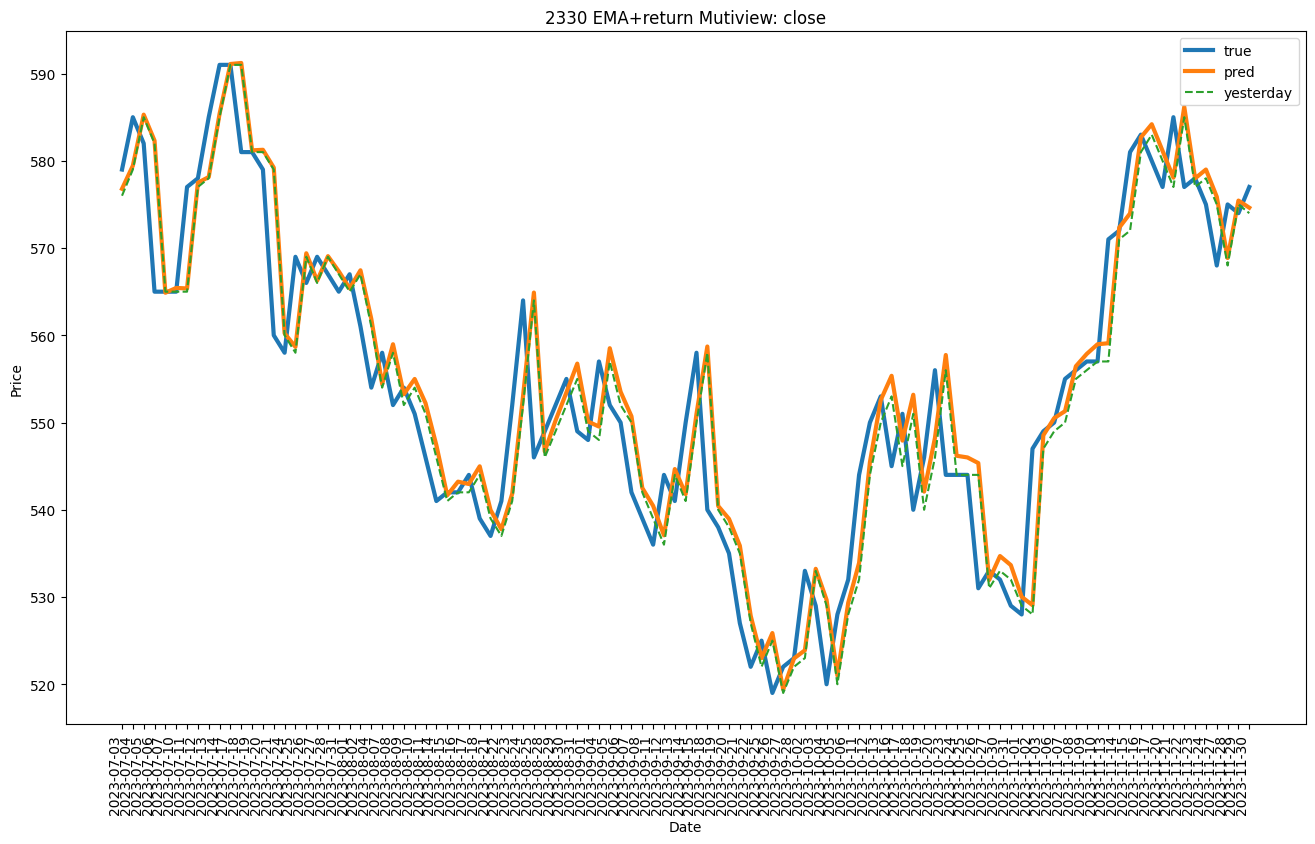

,Date,Observations,Predictions,Yesterday
0,2023-07-03,579.0,576.793031,576.0
1,2023-07-04,585.0,579.444308,579.0
2,2023-07-05,582.0,585.292990,585.0
3,2023-07-06,565.0,582.317562,582.0
4,2023-07-07,565.0,564.875949,565.0
...,...,...,...,...
100,2023-11-24,575.0,579.002003,578.0
101,2023-11-27,568.0,575.879068,575.0
102,2023-11-28,575.0,568.858458,568.0
103,2023-11-29,574.0,575.444995,575.0


In [22]:
mutiview = make_result(mutiview_result=mutiview_result)
mutiview